In [1]:
import sys
import pickle
from scipy import signal
from scipy import stats
import numpy as np
from sklearn.model_selection import ShuffleSplit
import math
from collections import OrderedDict


import matplotlib.pyplot as plt

sys.path.append('D:\Diamond\code')
from csp_james_2 import *

sys.path.append('D:\Diamond\code')
from thesis_funcs_19_03 import *

import torch
import torch.nn as nn
import torch.nn.functional as nnF
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler

import csv
import datetime


In [43]:
k_fold = 5

FS= [512]
num_epoch = 300

classes_all = [0,1] 

meth = 'gold_stand' #gold_stand，tl_comp_csp_kld , tl_comp_csp_mi
config_root= 'E:\\Diamond\\bci_iv\\MODELS\\fbcsp_mibif_cnn\\2a\\configs\\'
feature_root = 'E:\\Diamond\\own_expo\\pilot_test\\'
save_root = feature_root


if meth == 'gold_stand':
    tl =  0 # tl = 1 if use lambda i.e. transfer learning is activated, if tl = 0, the lambda = 0, i.e. gold standard - no transfer learning applied
elif meth == 'tl_comp_csp_kld' or meth == 'tl_comp_csp_mi':
    tl = 1




In [32]:
###################################################################################################################
                #load best config
###################################################################################################################
#load in cv config grid
hp_names  =[] #all the hyper-parameter names to be validated
cv_config = []



with open(config_root +'cv_config.csv', mode = 'r') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter = ',')
    for row in csv_reader:
        hp_names.append((row[0]).strip())
        cv_config.append(row)

#apppending _lambda config into cv_config of NN model     
with open(config_root +'_lambda_config.csv', mode = 'r') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter = ',')
    for row in csv_reader:
        hp_names.append((row[0]).strip())

        if tl == 0:
            cv_config.append(row[0:2])
        elif tl == 1:
            cv_config.append(row)
        
        
#strip away extra white spaces
for row in range (0, len(cv_config)):
    for i in range (0, len(cv_config[row])):
        cv_config[row][i] = cv_config[row][i].strip()    
        

In [51]:
to_save = 1

signal_len = '15s_end25s'

In [52]:
num_inits = 5
for subject in range (3,4):
    sub_id = 's' + str(subject)
    
    for portion_train in [1]:
        print (portion_train)
        
        for run_win in range (0,1):
            if run_win == 0:
                file_root_feature =  feature_root + sub_id + '\\models\\' + signal_len + '\\pt_' + str(int(portion_train*100))
                file_root_save = save_root + sub_id + '\\models\\'  + signal_len + '\\pt_' + str(int(portion_train*100))
                #len_inp = 44
            elif run_win == 1:
                file_root_feature = feature_root + + sub_id + '\\models' + '\\2s\\' + 'pt_' + str(int(portion_train*100))
                file_root_save = save_root + sub_id + '\\models' + '\\2s\\' + 'pt_' + str(int(portion_train*100))
                #len_inp = 25
                
            LABELS0_go = pickle.load(open(file_root_feature + '\\LABELS0_go.pickle', 'rb'))
            TRAIN_IDX = pickle.load(open(file_root_feature  + '\\TRAIN_IDX.pickle', 'rb'))
            TEST_IDX = pickle.load(open(file_root_feature + '\\TEST_IDX.pickle', 'rb')) 
            
            
            batch_size = np.shape(TRAIN_IDX)[-1]
            
            
            if to_save == 1:
                filewrite = open(file_root_save + '\\ANN\\best_config_val.txt', 'w')
                filewrite.write('')
                filewrite.close()
                
                filewrite = open(file_root_save + '\\ANN\\log_val.txt', 'w')
                filewrite.write('')
                filewrite.close()
                
           ################################################################################################
            #initialize config orddictionary
            config = OrderedDict() #current config: hyper-parameter name, hyperparametre value
            config_result = OrderedDict() # unique config as strings and its ANN results
            virgin = 1

            for hp_name in hp_names:
                config[hp_name] = init_hp_val (hp_name, hp_names, cv_config)
            
            config_result[make_config_str(config)] = []  

            best_config = make_config_str(config)
            best_config_acc = -1
            best_config_acc_all_inits_folds = []
            
            for i in range (0, k_fold * num_inits):
                best_config_acc_all_inits_folds.append(-1)
            ################################################################################################ 
            
            for round in range (0, 5):
                #loop through and generate new challenger config
                for hp_defender in hp_names:
                    #print (hp_defender)
                    hp_ind = hp_names.index(hp_defender)

                    best_val = config[hp_defender]
                    #make challenger config
                    for val in cv_config[hp_ind][1:]:
                        config[hp_defender] = val
                        
                        #proceeed only if non-repeating config
                        if virgin == 1 or (make_config_str(config) not in config_result.keys()):
                   ################################################################################################
                            #print (make_config_str(config))
                            #print (config_result.keys())
                            virgin = 0

                            ACC = []
                            for n_inits in range (0, num_inits):
                                #print (val, n_inits)
                                ###############################################################################################################################
                                for fold in range (0, k_fold):
                                    #print (fold)


                                    train_idx0 = TRAIN_IDX[fold]
                                    test_idx0 = TEST_IDX[fold]

                                    trn_ind_map = np.arange(0,len(train_idx0))
                                    tst_ind_map = np.arange(0,len(test_idx0))

                                    random.shuffle(trn_ind_map)
                                    random.shuffle(tst_ind_map)

                                    y_train = LABELS0_go[train_idx0[trn_ind_map]]
                                    y_test = LABELS0_go[test_idx0[tst_ind_map]]
                                

                                    X_train0 = pickle.load(open(file_root_feature + '\\Z_all_classes_train_fold_' + str(fold) + 
                                                                '_lambda_' + str(float(config['_lambda'].strip())) + ".pickle", 'rb'))

                                    X_test0 = pickle.load(open( file_root_feature + '\\Z_all_classes_test_fold_' + str(fold) + 
                                                               '_lambda_' + str(float(config['_lambda'].strip())) + ".pickle", 'rb'))


                                    X_train0 = X_train0[trn_ind_map]
                                    X_test0 = X_test0[tst_ind_map]

                                    #reshape to fit 2d covolution ( 1d doesnt work)
                                    X_train = np.reshape(X_train0, [np.shape(X_train0)[0], 1, np.shape(X_train0)[1], np.shape(X_train0)[2]]).astype('float64')
                                    X_test = np.reshape(X_test0, [np.shape(X_test0)[0], 1, np.shape(X_test0)[1], np.shape(X_test0)[2]]).astype('float64')

                                    #convert to torch tensors for NN training
                                    X_train = torch.from_numpy(X_train).float()
                                    X_test = torch.from_numpy(X_test).float()
                                    y_train = torch.from_numpy(y_train).long()
                                    y_test = torch.from_numpy(y_test).long()

                                    


                                    #initilize model
                                    model = Model_current(chn_inp = X_train.size()[-2], len_inp = X_train.size()[-1], nf = int(config['nf']), ks = int(config['ks']) , 
                                                  stride = int(config['stride']), act_f = config['act_fun'], nfc = int(config['nfc']))

                                    Loss = nn.CrossEntropyLoss()

                                    if config['optim'] == 'SGD':
                                        lr = 0.2
                                        optimizer = optim.SGD(model.parameters(), lr = lr)
                                        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor= 0.5, min_lr=0.001, cooldown = 5)

                                    elif 'ADAM_' in config['optim']:
                                        lr = float(config['optim'].split('_')[1])
                                        optimizer = optim.Adam(model.parameters(), lr = lr)
                                        scheduler = None


                                    ###############################################################################################################################         
                                    #set save_path to None if we dont want to save the nn weights
                                    save_path = None
                                    if to_save == 1:
                                        save_path = file_root_save + '\\ANN\\model_config_'+ str(make_config_str(config)) + '_' + 'n_inits_' + str(n_inits)+ '_fold_' + str(fold) + '.pt'

                                    #Train and test NN and save the best weights
                                    Train_acc_c, Test_acc_c, Train_loss, Test_loss, best_epoch, best_eval_acc, best_eval_acc_c = train_test_NN(
                                        save_path, X_train, y_train.long(), X_test, y_test.long(), 
                                                      model, Loss, optimizer, scheduler, num_epoch, batch_size, classes_all)

                                    if to_save == 1:
                                        pickle.dump( Train_acc_c, open(file_root_save + '\\ANN\\Train_acc_c_config_'+ make_config_str(config) + '_' + str(n_inits)+ '_fold_' + str(fold) + ".pickle", "wb" ) )
                                        pickle.dump( Test_acc_c, open(file_root_save +  '\\ANN\\Test_acc_c_config_'+ make_config_str(config) + '_' + str(n_inits)+  '_fold_' + str(fold) + ".pickle", "wb" ) )
                                    
                                    plot= 0
                                    if n_inits == 0 and plot == 1:
                                        plt.plot(np.average(Train_acc_c, axis = 1), 'b')
                                        plt.plot(np.average(Test_acc_c, axis = 1), 'r')
                                        plt.show()



                                    #calc accuracy
                                    fold_ave = np.average(best_eval_acc_c)
                                    #print ('fold', fold, ' fold acc ', fold_ave)
                                    ACC.append(fold_ave)
                                ###############################################################################################################################
                            config_result[make_config_str(config)] = [np.average(ACC)]

                            if to_save == 1:
                                pickle.dump(ACC, open(file_root_save + '\\ANN\\ACC_' + make_config_str(config) + '.pickle', 'wb'))
                                
                            if np.average(ACC) > best_config_acc:
                                w,p = stats.wilcoxon(ACC, best_config_acc_all_inits_folds)

                                if to_save == 1:
                                    filewrite = open(file_root_save + '\\ANN\\log_val.txt', 'a')
                                    filewrite.write(make_config_str(config) + ' ' + str(np.average(ACC)) + 
                                                        ' wil_'+ str(w) + '_' + str(p/2.0))
                                    if p/2.0 < 0.05:
                                        filewrite.write(' ACCEPTED' + '\n')
                                    else:
                                        filewrite.write(' REJECTED' + '\n')

                                    filewrite.close()


                                if p/2.0 < 0.05:
                                    best_val = val
                                    best_config = make_config_str(config)
                                    best_config_acc  = np.average(ACC)
                                    best_config_acc_all_inits_folds = ACC

                                    #save w, p, current, previous config name
                                    if to_save == 1:
                                        filewrite = open(file_root_save + '\\ANN\\best_config_val.txt', 'a')

                                        filewrite.write(best_config + ' ' + str(best_config_acc) + 
                                                        ' wil_'+ str(w) + '_' + str(p/2.0) +  '\n')
                                        filewrite.close()

                    ################################################################################################            
                    config[hp_defender] = best_val                 

1


In [39]:

file_root_save

'E:\\Diamond\\own_expo\\pilot_test\\s2\\models\\4s\\pt_100'

(71,)

In [53]:
print ('end')

end


In [74]:
to_save

1

In [54]:
acc = pickle.load(open('E:\\Diamond\\own_expo\\pilot_test\\s3\\models\\15s_end25s\\pt_100\\ANN\\Test_acc_c_config__act_fun_leaky_relu_nf_8_ks_4_stride_2_nfc_20_optim_ADAM_0.001__lambda_0_1_fold_3.pickle', 'rb'))

In [55]:
np.shape(acc)

(300, 2)

In [56]:
acc

[array([0.66666667, 0.6       ]),
 array([0.33333333, 0.93333333]),
 array([0.13333333, 1.        ]),
 array([0.06666667, 1.        ]),
 array([0.06666667, 1.        ]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0.        , 0.93333333]),
 array([0.        , 0.93333333]),
 array([0.        , 0.93333333]),
 array([0.26666667, 0.86666667]),
 array([0.26666667, 0.86666667]),
 array([0.46666667, 0.8       ]),
 array([0.46666667, 0.8       ]),
 array([0.53333333, 0.53333333]),
 array([0.6       , 0.53333333]),
 array([0.6       , 0.53333333]),
 array([0.6       , 0.46666667]),
 array([0.6, 0.4]),
 array([0.6, 0.4]),
 array([0.6, 0.4]),
 array([0.6       , 0.46666667]),
 array([0.6       , 0.33333333]),
 array([0.6, 0.4]),
 array([0.6, 0.4]),
 array([0.66666667, 0.4       ]),
 array([0.66666667, 0.4       ]),
 array([0.66666667, 0.4       ]),
 array([0.66666667, 0.4       ]),
 array([0.66666667, 0.4       ]),
 array([0.

In [20]:
round

4

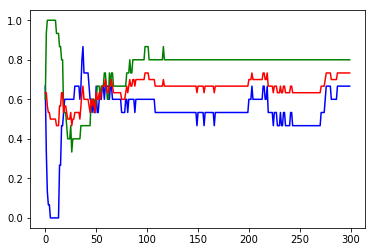

In [57]:
acc = np.array(acc)
plt.plot(acc[:,0], 'b')
plt.plot(acc[:,1], 'g')

plt.plot(np.average(acc, axis = 1), 'r')

In [58]:
X_train.size()

torch.Size([30, 1, 16, 77])

In [60]:
file_root_feature

'E:\\Diamond\\own_expo\\pilot_test\\s3\\models\\15s_end25s\\pt_100'

In [53]:
np.average(acc, axis = 1)

array([0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.52777778, 0.52777778,
       0.52777778, 0.52777778, 0.52777778, 0.52777778, 0.52777778,
       0.52777778, 0.55555556, 0.55555556, 0.58333333, 0.61111111,
       0.61111111, 0.61111111, 0.63888889, 0.63888889, 0.66666667,
       0.69444444, 0.72222222, 0.69444444, 0.66666667, 0.66666667,
       0.66666667, 0.66666667, 0.69444444, 0.69444444, 0.69444444,
       0.69444444, 0.72222222, 0.72222222, 0.72222222, 0.72222222,
       0.75      , 0.77777778, 0.72222222, 0.69444444, 0.66666667,
       0.63888889, 0.66666667, 0.66666667, 0.61111111, 0.61111111,
       0.61111111, 0.63888889, 0.72222222, 0.72222222, 0.72222222,
       0.69444444, 0.69444444, 0.69444444, 0.66666667, 0.66666